## 6 May 2020:
## **THIS IS revised VERSION OF ZI'S ORIGINAL**

TAKEN FROM GITHUB ON APRIL 23, 2020
https://github.com/Karuntg/SDSS_SSC/raw/master/analysis/sdss_gaia_matching.ipynb

## **SEE ADDNL INFO REG GAIA PHOT CALIB AT**

https://gea.esac.esa.int/archive/documentation/GDR1/Data_processing/chap_cu5phot/sec_phot_calibr.html

**CHANGES DONE**
1. FOCUS ENTIRELY ON THE ESA GAIA ANALYSIS/ PLOTS
2. PLOTS DONE: Gg vs gr, gi, gz, and Gi vs ri
3. FIT ONLY 3RD ORDER POLYNOMIALS
4. FOR ALL OTHER ANALYSES/ PLOTS REFER TO V1

In [1]:
# workhorse packages
import matplotlib.pyplot as plt 
import numpy as np

# Data handling
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack

# for fits with log likelihood
import scipy
from scipy import stats
from scipy import optimize

# for plotting histograms
from astroML.plotting import hist


## **DEFINE CAT NAMES, ETC.**

In [2]:
SDSS_CAT = 'stripe82calibStars_v2.6.dat'
GAIA_CAT = 'Stripe82_GaiaDR1.dat'

# MATCHED GAIA-SDSS OBJECTS
SDSS2GAIA = 'S82_SDSS2GAIA_matchkln.csv'

# MAGS/ERRS OF MATCHED GAIA-SDSS OBJECTS
SDSS2GAIA_magerr = 'S82_SDSS2GAIA_matchkln_magerr.csv'

## **DEFINE PROG CONSTS**

In [3]:
# CONVERT IQD TO STD DEV
IQD2STD = 0.741

# GAIA ZEROPOINT
GAIA_ZP = 25.525

# DEFINE POLYNOMIAL DEGREES
deg1,deg2,deg3,deg5,deg7 = 1,2,3,5,7

## **Read the sdss and gaia catalogs** 

Goes quite slowly, consider DASK?

In [4]:
%%time
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

sdss = Table.read(SDSS_CAT, format='ascii', names=colnames)

CPU times: user 42.3 s, sys: 10 s, total: 52.3 s
Wall time: 52.4 s


In [5]:
%%time
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr']
# gaia = Table.read('Stripe82_GaiaDR1_small.dat', format='ascii', names=colnames)
gaia = Table.read(GAIA_CAT, format='ascii', names=colnames)

CPU times: user 46.9 s, sys: 4.85 s, total: 51.7 s
Wall time: 51.7 s


## **Match gaia to sdss, since here sdss is much larger** 

In [6]:
# PRINT OUT NUMBER OF OBJ READ
print('Num 2007 cat obj: {0}'.format(len(sdss['ra'])))
print('Num gaia obj: {0}'.format(len(gaia['ra'])))

Num 2007 cat obj: 1006849
Num gaia obj: 715436


In [7]:
%%time
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['ra']*u.degree, dec= gaia['dec']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(sdss_coords)  


CPU times: user 2.81 s, sys: 1.92 ms, total: 2.81 s
Wall time: 2.81 s


## **HERE ARE ALL THE DATAFRAMES AND SELECTION CUTS**

### THIS IS THE PRIMARY DF AFTER SDSS-GAIA MATCHING

### gaia_sdss

In [8]:
# THIS IS THE PRIMARY DF AFTER SDSS-GAIA MATCHING
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
# since it's matching gaia to sdss,
# the resulting catalog has the same length 
# as gaia ... 
gaia_sdss = hstack([gaia, sdss[idx]], table_names = ['gaia', 'sdss'])
gaia_sdss['sep_2d_arcsec'] = d2d.arcsec
print('Num gaia-SDSS 2007 matched: {0}'.format(len(idx)))
print(gaia_sdss.info())


Num gaia-SDSS 2007 matched: 715436
<Table length=715436>
     name      dtype 
------------- -------
      ra_gaia float64
     dec_gaia float64
         nObs float64
         Gmag float64
         flux float64
      fluxErr float64
    calib_fla   str10
      ra_sdss float64
     dec_sdss float64
        raRMS float64
       decRMS float64
      nEpochs   int64
       AR_val float64
       u_Nobs   int64
       u_mMed float64
      u_mMean float64
       u_mErr float64
  u_rms_scatt float64
       u_chi2 float64
       g_Nobs   int64
       g_mMed float64
      g_mMean float64
       g_mErr float64
  g_rms_scatt float64
       g_chi2 float64
       r_Nobs   int64
       r_mMed float64
      r_mMean float64
       r_mErr float64
  r_rms_scatt float64
       r_chi2 float64
       i_Nobs   int64
       i_mMed float64
      i_mMean float64
       i_mErr float64
  i_rms_scatt float64
       i_chi2 float64
       z_Nobs   int64
       z_mMed float64
      z_mMean float64
       z_mErr float

### **GET ALL THE REQUIRED QUANTITIES**

1. MAGS AND COLORS FROM SDSS AND GAIA
2. POSITIONS FROM GAIA ONLY

**_all**

In [9]:
r_all = gaia_sdss['r_mMed']
G_all = gaia_sdss['Gmag']

# sdss colors
gr_all = gaia_sdss['g_mMed'] - gaia_sdss['r_mMed']
gi_all = gaia_sdss['g_mMed'] - gaia_sdss['i_mMed']
gz_all = gaia_sdss['g_mMed'] - gaia_sdss['z_mMed']
ri_all = gaia_sdss['r_mMed'] - gaia_sdss['i_mMed']
# Gaia colors
Gg_all = gaia_sdss['Gmag'] - gaia_sdss['g_mMed']
Gr_all = gaia_sdss['Gmag'] - gaia_sdss['r_mMed']
Gi_all = gaia_sdss['Gmag'] - gaia_sdss['i_mMed']

ra_all = gaia_sdss['ra_gaia'] 
raW_all = np.where(ra_all > 180, ra_all-360, ra_all)
dec_all = gaia_sdss['dec_gaia']

### SELECTION I:  BASED ON MATCH DISTANCE

SELECT WITH DIST < 0.5 ARC.SEC

#### gaia_matched

In [10]:
# I would call good match to be within a certain limit 
# there is no built-in boundary - match_to_catalog_sky()
# will find the nearest match, regardless if it's an arcsecond
# or five degrees to the nearest one.

# gaia sources that have a good sdss match 
flag = (gaia_sdss['sep_2d_arcsec'] < 0.5)  # 486812 for <1 arcsec
gaia_matched = gaia_sdss[flag]
print('Num matched obj: %d' % len(gaia_sdss))
print('Num dist < 0.5 arc.sec: %d' % len(gaia_matched))

Num matched obj: 715436
Num dist < 0.5 arc.sec: 466598


### **PICK ALL THE REQUIRED QUANTITIES WITH SELECTION I**

1. MAGS AND COLORS FROM SDSS AND GAIA
2. POSITIONS FROM GAIA ONLY

**_pk1**

In [11]:
## MAGS AND COLORS
r_pk1 = gaia_matched['r_mMed']
G_pk1 = gaia_matched['Gmag']
# sdss colors
gr_pk1 = gaia_matched['g_mMed'] - gaia_matched['r_mMed']
gi_pk1 = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
gz_pk1 = gaia_matched['g_mMed'] - gaia_matched['z_mMed']
ri_pk1 = gaia_matched['r_mMed'] - gaia_matched['i_mMed']
# gaia colors
Gg_pk1 = gaia_matched['Gmag'] - gaia_matched['g_mMed']
Gr_pk1 = gaia_matched['Gmag'] - gaia_matched['r_mMed']
Gi_pk1 = gaia_matched['Gmag'] - gaia_matched['i_mMed']

# POSITIONS BASED ON GAIA
ra_pk1 = gaia_matched['ra_gaia'] 
raW_pk1 = np.where(ra_pk1 > 180, ra_pk1-360, ra_pk1)
dec_pk1 = gaia_matched['dec_gaia']


### **SELECTION II: BY RA, RMAG AND SDSS GI COLOR**

flagOK = ((raW_pk1 > -10) & (raW_pk1 < 50) & (r_pk1>16) & (r_pk1<19) & (gi_pk1>0) & (gi_pk1<3.0))

#### gaia_matchedOK

In [12]:
# flagOK = ((raW > -10) & (raW < 50) & (rMed>15) & (rMed<20))
# flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19))
flagOK = ((raW_pk1 > -10) & (raW_pk1 < 50) & (r_pk1>16) & (r_pk1<19) & (gi_pk1>0) & (gi_pk1<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print('Num obj after select by RA, rMag, gi color: %d' % (len(gaia_matchedOK)))

Num obj after select by RA, rMag, gi color: 90516


### PICK ALL THE REQUIRED QUANTITIES WITH SELECTION II**

1. MAGS AND COLORS FROM SDSS AND GAIA
2. POSITIONS FROM GAIA ONLY

**_pk2**

In [13]:
g_pk2 = gaia_matchedOK['g_mMed']
r_pk2 = gaia_matchedOK['r_mMed']
i_pk2 = gaia_matchedOK['i_mMed']
z_pk2 = gaia_matchedOK['z_mMed']

G_pk2 = gaia_matchedOK['Gmag']
# sdss colors
gr_pk2 = gaia_matchedOK['g_mMed'] - gaia_matchedOK['r_mMed']
gi_pk2 = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
gz_pk2 = gaia_matchedOK['g_mMed'] - gaia_matchedOK['z_mMed']
ri_pk2 = gaia_matchedOK['r_mMed'] - gaia_matchedOK['i_mMed']
# Gaia colors
Gg_pk2 = gaia_matchedOK['Gmag'] - gaia_matchedOK['g_mMed']
Gr_pk2 = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed']
Gi_pk2 = gaia_matchedOK['Gmag'] - gaia_matchedOK['i_mMed']

ra_pk2 = gaia_matchedOK['ra_gaia'] 
raW_pk2 = np.where(ra_pk2 > 180, ra_pk2-360, ra_pk2)
dec_pk2 = gaia_matchedOK['dec_gaia'] 

### **SELECTION III: INCLUDE GAIA GMAG WITH SELECTION II**

flagOK = ((raW_pk2 > -10) & (raW_pk2 < 50) & (r_pk2>16) & (r_pk2<19) & (gi_pk2>0) & (gi_pk2<3.0))

flagOK2 = (flagOK & (G_pk2 > 16) & (G_pk2 < 16.5))

#### gaia_matchedOK2

In [14]:
flagOK = ((raW_pk2 > -10) & (raW_pk2 < 50) & (r_pk2>16) & (r_pk2<19) & (gi_pk2>0) & (gi_pk2<3.0))

flagOK2 = (flagOK & (G_pk2 > 16) & (G_pk2 < 16.5))
gaia_matchedOK2 = gaia_matchedOK[flagOK2]
print('Num obj after select by RA, rMag, gi color: %d' % len(gaia_matchedOK))
print('Num obj after Gaia G-mag cut: %d' % len(gaia_matchedOK2))

Num obj after select by RA, rMag, gi color: 90516
Num obj after Gaia G-mag cut: 10710


In [15]:
print(len(flagOK2))

90516


### **PICK ALL THE REQUIRED QUANTITIES WITH SELECTION III**

1. MAGS AND COLORS FROM SDSS AND GAIA
2. POSITIONS FROM GAIA ONLY

**NOTE** Also get the mag errs for sdss griz and Gaia Gmag. These are needed for the next selection cut

**_pk3**

In [16]:
g_pk3 = gaia_matchedOK2['g_mMed']
r_pk3 = gaia_matchedOK2['r_mMed']
i_pk3 = gaia_matchedOK2['i_mMed']
z_pk3 = gaia_matchedOK2['z_mMed']

G_pk3 = gaia_matchedOK2['Gmag']

# also get mag errors for the next selection cut
# Gaia err
Gflux_pk3 = gaia_matchedOK2['flux']
Gfluxerr_pk3 = gaia_matchedOK2['fluxErr']
G_err_pk3 = -2.5*np.log10(1.+ (Gfluxerr_pk3/Gflux_pk3))

# sdss errs
g_err_pk3 = gaia_matchedOK2['g_mErr']
r_err_pk3 = gaia_matchedOK2['r_mErr']
i_err_pk3 = gaia_matchedOK2['i_mErr']
z_err_pk3 = gaia_matchedOK2['z_mErr']

# sdss colors
gr_pk3 = gaia_matchedOK2['g_mMed'] - gaia_matchedOK2['r_mMed']
gi_pk3 = gaia_matchedOK2['g_mMed'] - gaia_matchedOK2['i_mMed']
gz_pk3 = gaia_matchedOK2['g_mMed'] - gaia_matchedOK2['z_mMed']
ri_pk3 = gaia_matchedOK2['r_mMed'] - gaia_matchedOK2['i_mMed']
# Gaia colors
Gg_pk3 = gaia_matchedOK2['Gmag'] - gaia_matchedOK2['g_mMed']
Gr_pk3 = gaia_matchedOK2['Gmag'] - gaia_matchedOK2['r_mMed']
Gi_pk3 = gaia_matchedOK2['Gmag'] - gaia_matchedOK2['i_mMed']

ra_pk3 = gaia_matchedOK2['ra_gaia'] 
raW_pk3 = np.where(ra_pk3 > 180, ra_pk3-360, ra_pk3)
dec_pk3 = gaia_matchedOK2['dec_gaia'] 

### **SELECTION IV: INCLUDE MAG ERR CUTS FOR SDSS G,R,I,Z, AND GAIA G MAG**

flagOK3 = ((G_err_pk3 < 0.01) & (g_err_pk3 < 0.01) & (r_err_pk3 < 0.01) & (i_err_pk3 < 0.01) & (z_err_pk3 < 0.01))

In [17]:
flagOK3 = ((G_err_pk3 < 0.01) & (g_err_pk3 < 0.01) & (r_err_pk3 < 0.01) & (i_err_pk3 < 0.01) & (z_err_pk3 < 0.01))
gaia_matchedOK3 = gaia_matchedOK2[flagOK3]
print('Num obj after select by Gaia mags: %d' % len(gaia_matchedOK2))
print('Num obj after Gaia G, SDSS griz err cuts: %d' % len(gaia_matchedOK3))

Num obj after select by Gaia mags: 10710
Num obj after Gaia G, SDSS griz err cuts: 10611


In [18]:
g_pk4 = gaia_matchedOK3['g_mMed']
r_pk4 = gaia_matchedOK3['r_mMed']
i_pk4 = gaia_matchedOK3['i_mMed']
z_pk4 = gaia_matchedOK3['z_mMed']

G_pk4 = gaia_matchedOK3['Gmag']

# also get mag errors for the next selection cut
# Gaia errs
Gflux_pk4 = gaia_matchedOK3['flux']
Gfluxerr_pk4 = gaia_matchedOK3['fluxErr']
G_err_pk4 = -2.5*np.log10(1.+ (Gfluxerr_pk4/Gflux_pk4))

# sdss errs
g_err_pk4 = gaia_matchedOK3['g_mErr']
r_err_pk4 = gaia_matchedOK3['r_mErr']
i_err_pk4 = gaia_matchedOK3['i_mErr']
z_err_pk4 = gaia_matchedOK3['z_mErr']

# SDSS clrs
gr_pk4 = gaia_matchedOK3['g_mMed'] - gaia_matchedOK3['r_mMed']
gi_pk4 = gaia_matchedOK3['g_mMed'] - gaia_matchedOK3['i_mMed']
gz_pk4 = gaia_matchedOK3['g_mMed'] - gaia_matchedOK3['z_mMed']
ri_pk4 = gaia_matchedOK3['r_mMed'] - gaia_matchedOK3['i_mMed']

# Gaia-SDSS clrs
Gg_pk4 = gaia_matchedOK3['Gmag'] - gaia_matchedOK3['g_mMed']
Gr_pk4 = gaia_matchedOK3['Gmag'] - gaia_matchedOK3['r_mMed']
Gi_pk4 = gaia_matchedOK3['Gmag'] - gaia_matchedOK3['i_mMed']

ra_pk4 = gaia_matchedOK3['ra_gaia'] 
raW_pk4 = np.where(ra_pk4 > 180, ra_pk4-360, ra_pk4)
dec_pk4 = gaia_matchedOK3['dec_gaia'] 

## **WRITE THIS MATCHED, CLEANED SDSS-GAIA DF TO FILE**

In [19]:
%%time
paths = SDSS2GAIA  
gaia_matchedOK2.write(paths,format='ascii.csv',
                      delimiter=',', comment='#',overwrite=True)


CPU times: user 488 ms, sys: 31.2 ms, total: 519 ms
Wall time: 517 ms


## **ALSO WRITE OUT ONLY THE SDSS-GAIA MAGS/ERRS**

**MAKE A SUBSET OF THE DF WITH ONLY GAIA RA, DEC, SDSS GRIZ MED MAGS, ERRS, GAIA GMAG, FLUX AND ERR**

In [20]:
# GET A SUBSET OF MAG/ERR COLS ONLY
cols_needed = ['ra_gaia','dec_gaia','Gmag','flux','fluxErr',
               'g_mMed','g_mErr','r_mMed','r_mErr','i_mMed','i_mErr','z_mMed','z_mErr']
gaia_matchedOK2_subset = gaia_matchedOK2[cols_needed]

# WRITE OUT A CSV FILE
paths = SDSS2GAIA_magerr
gaia_matchedOK2_subset.write(paths,format='ascii.csv',
                      delimiter=',', comment='#',overwrite=True)


## **FUNCTION DEFINITIONS**

### **fitMedians for fitting med and std dev in bins over a x,y distribution**

In [21]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i], medianBin[i], sigGBin[i] = 0
        
    if (verbose):
        print('median:', np.median(medianBin[Npts>0]))

    return xBin, nPts, medianBin, sigGbin

### mag2flux = convert SDSS mag to flux with ZP = 0

In [22]:
def mag2flx(SDSSmag):
    Flux = 10**(0.4*SDSSmag)
    return Flux

### **best_theta = fits a polynomial for a given (x, y, sigma_y)**

In [23]:
# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logLv0(data, theta, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(data, degree, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logLv0 = lambda theta: -logLv0(data, theta, model)
    return optimize.fmin_bfgs(neg_logLv0, theta_0, disp=False)


### **best_lintheta = fits a linear function of several vars,  (x, w, y, z, f, sigma_f)**

In [24]:
# this function computes a linear combination of 4 functions
# given parameters theta
def linear_fit(coeffs, x, w, y, z):
    ffit = coeffs[0]*x + coeffs[1]*w + coeffs[2]*y + coeffs[3]*z 
    return ffit

# compute the data log-likelihood given a model
def logLv1(dataL, coeffs, model=linear_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, w, y, z, f, sigma_f = dataL
    f_fit = model(coeffs, x, w, y, z)
    return sum(stats.norm.logpdf(*args)
               for args in zip(f, f_fit, sigma_f))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_lintheta(dataL, degree=4, model=linear_fit):
    coeffs_0 = degree * [0]
    neg_logLv1 = lambda coeffs: -logLv1(dataL, coeffs, model)
    return optimize.fmin_bfgs(neg_logLv1, coeffs_0, disp=False)


## **PLOTS**

### **ONLY CCD**

In [25]:
# FUNCTION TO PLOT THE CCD, FIT THE POLY, AND OVERPLOT THE FITTED VALUES
def CCDpltNfit(clr1a,clr1b,clr1c,clr1d,clr2a,clr2b,clr2c,clr2d,labls,
               xlim,ylim,ax_labl,plt_titl,fitclr1,fitclr2,Binz,degr=3):
    # clr1a,clr1b,clr1c,clr1d = the four cuts on clr on x-axis
    # clr2a,clr2b,clr2c,clr2d = the four cuts on clr on y-axis
    # labls = labels for the datasets given as a 4-element list
    # xlim, ylim = plot limits on x and y as 2-element lists
    # ax_labl,plt_titl = axes labels, and plot title
    # fitclr1,fitclr2 = cut on clr1, clr2 with which to comp medians and fit poly
    # Binz = minx, maxx and nbins for fitting range
    # degr = degree of fit poly, default = 3
    
    # plot the base CCD
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.scatter(clr1a,clr2a, s=0.01, c='orange',label=labls[0])
    ax.scatter(clr1b,clr2b, s=0.01, c='green',label=labls[1])
    ax.scatter(clr1c,clr2c, s=0.01, c='blue',label=labls[2])
    ax.scatter(clr1d,clr2d, s=0.01, c='red',label=labls[3])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(ax_labl[0])
    ax.set_ylabel(ax_labl[1])
    ax.set_title(plt_titl,fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.legend(loc='best')
    ax.grid(True)

    plt.show()
    
    # now fit the medians to the specified data set
    minx,maxx,nbin = Binz[0],Binz[1],Binz[2]
    xBin, nPts, medBin, sigBin = fitMedians(fitclr1,fitclr2,minx,maxx,nbin,0)
    
    # now fit the poly of spec degr
    data = np.array([xBin,medBin,sigBin])
    theta = best_theta(data,degr)

    return xBin, nPts, medBin, sigBin,theta



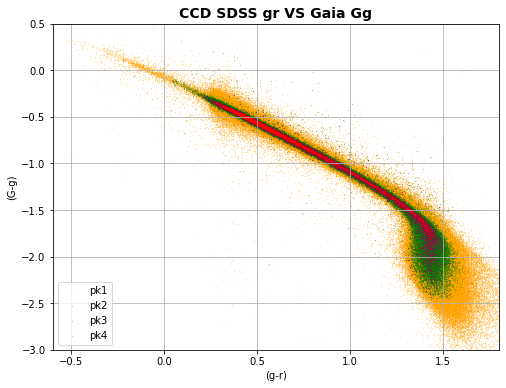

[-0.10196622 -0.87873028 -0.07714553 -0.03672245]


In [26]:
clr1a,clr1b,clr1c,clr1d = gr_pk1,gr_pk2,gr_pk3,gr_pk4
clr2a,clr2b,clr2c,clr2d = Gg_pk1,Gg_pk2,Gg_pk3,Gg_pk4
labls = ['pk1','pk2','pk3','pk4']
xlim = (-0.6,1.8)
ylim = (-3.0,0.5)
ax_labl = ['(g-r)','(G-g)']
plt_titl = 'CCD SDSS gr VS Gaia Gg'
fitclr1,fitclr2 = gr_pk4,Gg_pk4
Binz = [0.2,1.2,20]
xBin, nPts, medBin, sigBin,theta = CCDpltNfit(clr1a,clr1b,clr1c,clr1d,clr2a,clr2b,clr2c,clr2d,labls,
               xlim,ylim,ax_labl,plt_titl,fitclr1,fitclr2,Binz,degr=3)
print(theta)

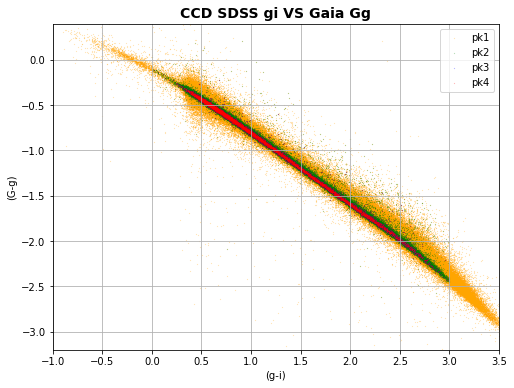

[-0.12288574 -0.55965707 -0.15323257  0.03253363]
CPU times: user 9.5 s, sys: 708 ms, total: 10.2 s
Wall time: 9.77 s


In [27]:
%%time
clr1a,clr1b,clr1c,clr1d = gi_pk1,gi_pk2,gi_pk3,gi_pk4
clr2a,clr2b,clr2c,clr2d = Gg_pk1,Gg_pk2,Gg_pk3,Gg_pk4
labls = ['pk1','pk2','pk3','pk4']
xlim = (-1.,3.5)
ylim = (-3.2,0.4)
ax_labl = ['(g-i)','(G-g)']
plt_titl = 'CCD SDSS gi VS Gaia Gg'
fitclr1,fitclr2 = gi_pk4,Gg_pk4
Binz = [0.5,2.5,30]
xBin, nPts, medBin, sigBin,theta = CCDpltNfit(clr1a,clr1b,clr1c,clr1d,clr2a,clr2b,clr2c,clr2d,labls,
               xlim,ylim,ax_labl,plt_titl,fitclr1,fitclr2,Binz,degr=3)
print(theta)

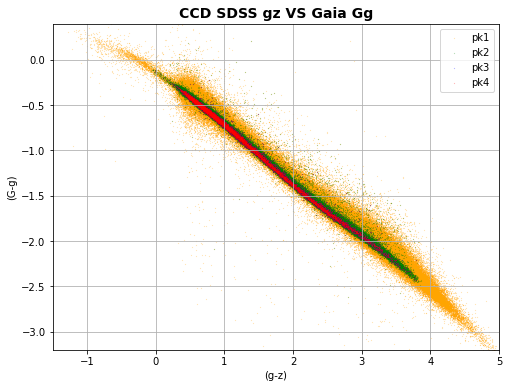

[-0.18161614 -0.39172906 -0.18203091  0.03950547]


In [28]:
clr1a,clr1b,clr1c,clr1d = gz_pk1,gz_pk2,gz_pk3,gz_pk4
clr2a,clr2b,clr2c,clr2d = Gg_pk1,Gg_pk2,Gg_pk3,Gg_pk4
labls = ['pk1','pk2','pk3','pk4']
xlim = (-1.5,5)
ylim = (-3.2,0.4)
ax_labl = ['(g-z)','(G-g)']
plt_titl = 'CCD SDSS gz VS Gaia Gg'
fitclr1,fitclr2 = gz_pk4,Gg_pk4
Binz = [0.5,3,35]
xBin, nPts, medBin, sigBin,theta = CCDpltNfit(clr1a,clr1b,clr1c,clr1d,clr2a,clr2b,clr2c,clr2d,labls,
               xlim,ylim,ax_labl,plt_titl,fitclr1,fitclr2,Binz,degr=3)
print(theta)

### CCD gr vs ri

CPU times: user 214 ms, sys: 171 ms, total: 385 ms
Wall time: 156 ms


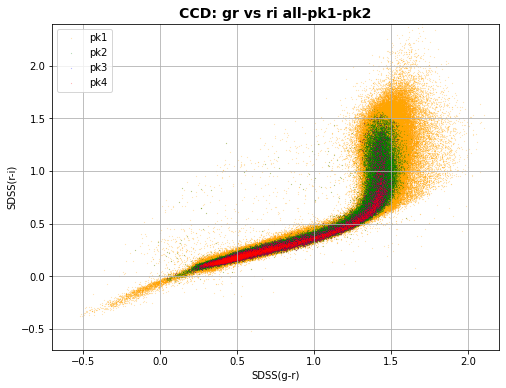

In [29]:
%%time
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
# ax.scatter(gr_all, ri_all, s=0.01, c='green')
ax.scatter(gr_pk1, ri_pk1, s=0.01, c='orange',label='pk1')
ax.scatter(gr_pk2, ri_pk2, s=0.01, c='green',label='pk2')
ax.scatter(gr_pk3, ri_pk3, s=0.01, c='blue',label='pk3')
ax.scatter(gr_pk4, ri_pk4, s=0.01, c='red',label='pk4')
ax.set_xlim(-0.7,2.2)
ax.set_ylim(-0.7,2.4)
ax.set_xlabel('SDSS(g-r)')
ax.set_ylabel('SDSS(r-i)')
ax.set_title('CCD: gr vs ri all-pk1-pk2',fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.legend(loc='best')
ax.grid(True)


### **LINEAR FIT OF SDSS GRIZ TO GAIA G**

In [30]:
%%time
# Gaia quantities
fluxGaia = Gflux_pk4
fluxGaiaErr = Gfluxerr_pk4
magGaiaErr = G_err_pk4
# sdss quantities
gFlux = 10**(0.4*g_pk4)
rFlux = 10**(0.4*r_pk4)
iFlux = 10**(0.4*i_pk4)
zFlux = 10**(0.4*z_pk4)
dataL = np.array([gFlux, rFlux, iFlux, zFlux, fluxGaia, fluxGaiaErr])
x, w, y, z, f, sigma_f = dataL
coeffs1 = best_lintheta(dataL)
ffit = linear_fit(coeffs1, x, w, y, z)
dmag = -2.5*np.log10(ffit/f) 

## PRINT OUT THE FIT RESULTS
Gmag_resd = dmag
Gmag_resd_exp = magGaiaErr
print('Med Gmag resd: ',np.median(Gmag_resd))
print('Med exp Gmag resd: ',np.median(Gmag_resd_exp))


Med Gmag resd:  0.08817320022466985
Med exp Gmag resd:  -0.002006413551267061
CPU times: user 8min 25s, sys: 101 ms, total: 8min 25s
Wall time: 8min 25s


### **PLOT FiT VS MEASURED GMAG AND RESIDUAL**

(-0.15, 0.15)

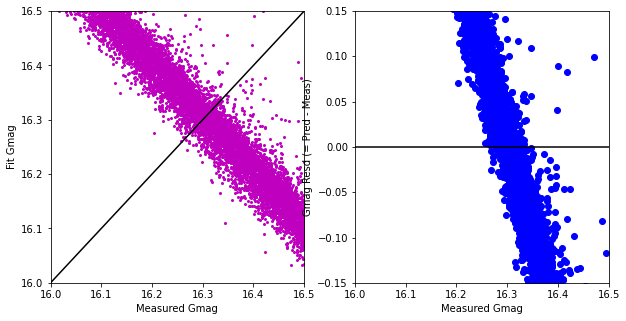

In [33]:
# Convert flux to mag
Gmag_fit = GAIA_ZP - 2.5*np.log10(ffit)
Gmag_msr = GAIA_ZP - 2.5*np.log10(Gflux_pk4)
Gmag_resd = Gmag_fit - Gmag_msr

# Plot train and val losses
%matplotlib inline
# plot
fig,ax = plt.subplots(1,2,figsize=(10,5))
# Plt 1: mag vs mag
xmin,xmax = 16,16.5
ax[0].plot(Gmag_msr,Gmag_fit,'mo',markersize=2)
ax[0].plot([xmin,xmax],[xmin,xmax],'k-')
ax[0].set_xlabel('Measured Gmag')
ax[0].set_ylabel('Fit Gmag')
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(xmin,xmax)

# Plt 2: mag vs resd
ax[1].plot(Gmag_msr,Gmag_resd,'bo')
ax[1].plot([xmin,xmax],[0,0],'k-')
ax[1].set_xlabel('Measured Gmag')
ax[1].set_ylabel('Gmag Resd (= Pred - Meas)')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(-0.15,0.15)

## **STOPPED HERE**

### CCD gi vs Gr

In [ ]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi_all, Gr_all, s=0.01, c='green')
ax.scatter(gi_pk1, Gr_pk1, s=0.01, c='blue')
ax.scatter(gi_pk2, Gr_pk2, s=0.01, c='red')
ax.set_xlim(-0.5,3.5)
ax.set_ylim(-1.5,1.)
ax.set_xlabel('SDSS(g-i)')
ax.set_ylabel('Gaia G - SDSS r')
ax.set_title('CCD: gi vs Gr all-pk1-pk2',fontdict={'fontsize': 14, 'fontweight': 'bold'})

### FIT MEDIANS IN BINS TO gi on the CCD

In [ ]:
%%time
# medians
#xBin, nPts, medianBin, sigGbin = fitMedians(gi, Gr, -0.7, 4.0, 47, 0)
#xBinOK, nPtsOK, medianBinOK, sigGbinOK = fitMedians(giOK, GrOK, -0.2, 3.2, 34, 0)
xBin, nPts, medianBin, sigGbin = fitMedians(gi_all, Gr_all, 0.0, 3.0, 30, 0)
xBinOK1, nPtsOK1, medianBinOK1, sigGbinOK1 = fitMedians(gi_pk1, Gr_pk1, 0.0, 3.0, 30, 0)
xBinOK2, nPtsOK2, medianBinOK2, sigGbinOK2 = fitMedians(gi_pk2, Gr_pk2, 0.0, 3.0, 30, 0)
xBinOK3, nPtsOK3, medianBinOK3, sigGbinOK3 = fitMedians(gi_pk3, Gr_pk3, 0.0, 3.0, 30, 0)

#print xBin, nPts, medianBin, sigGbin
medOK1 = medianBinOK1[(xBinOK1>2)&(xBinOK1<3)]
medOK2 = medianBinOK2[(xBinOK2>2)&(xBinOK2<3)]
medOK3 = medianBinOK3[(xBinOK3>2)&(xBinOK3<3)]
dmedOK21 = medOK2 - medOK1
dmedOK32 = medOK3 - medOK2
print('Med offset pk2 - pk1: ',dmedOK21)
print('Med offset pk3 - pk2: ',dmedOK32)

### FIT POLYNOMIAL TO THE gi MEDIANS

**TRY ORDER = 1**

In [ ]:
%%time
data = np.array([xBinOK1, medianBinOK1, sigGbinOK1])
#x, y, sigma_y = data
theta1 = best_theta(data,deg1)
print('Fit values: ',theta1)

## **USE POLYNOMIAL FITS OF DIFFERENT ORDERS**

**USE _PK2**

**ORDERS TESTED: 3,5,7**

In [ ]:
%%time
data = np.array([xBinOK2, medianBinOK2, sigGbinOK2])
# x, y, sigma_y = data
Ndata = xBinOK2.size
# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(data,deg3)
theta2 = best_theta(data,deg5)
theta3 = best_theta(data,deg7)



## **USE COEFFTS TO GENERATE FITTED VALUES**

**COMPARE WITH Y-VALUES, ESTIMATE CHI2**

In [ ]:
# generate best fit lines on a fine grid 
xfit = np.linspace(-1.1, 4.3, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)

# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
x, y, sigma_y = xBinOK2, medianBinOK2, sigGbinOK2
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - deg3)
chi2dof2 = chi22/(Ndata - deg5)
chi2dof3 = chi23/(Ndata - deg7)

print("CHI2:")
print('   Model deg, chi2 :', deg3,chi21)
print('Model deg, chi2 ::', deg5, chi22)
print('    Model deg, chi2 ::', deg7, chi23)
print("CHI2 per degree of freedom:")
print('   best model 1:', chi2dof1)
print('best model 2:', chi2dof2)
print('    best model 3:', chi2dof3)

In [ ]:
# Plot a (gaia - r)  vs (g-i)  for photometric transformation
%matplotlib inline
# plot
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(gi_pk1, Gr_pk1, s=0.01, c='green')
ax.scatter(gi_pk2, Gr_pk2, s=0.01, c='blue')
ax.scatter(gi_pk3, Gr_pk3, s=0.01, c='red')
# medians
ax.scatter(xBinOK1, medianBinOK1, s=30.0, c='black', alpha=0.5)
ax.scatter(xBinOK2, medianBinOK2, s=30.0, c='yellow', alpha=0.5)
ax.scatter(xBinOK2, medianBinOK2, s=30.0, c='green', alpha=0.5)
ax.set_xlim(-1,4)
ax.set_ylim(-2.0,0.5)
ax.set_xlabel('SDSS(g-i)')
ax.set_ylabel('Gaia G - SDSS r')
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best P3 model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best P5 model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best P7 model')
ax.legend(loc='best', fontsize=14)


In [ ]:
print('Coeffts 3rd order fit: ',theta3)

In [ ]:
# GrModel = -0.06348 -0.03111*gi +0.08643*gi*gi -0.05593*gi*gi*gi
GrModel = sum(t * gi_pk2 ** n for (n, t) in enumerate(theta3))

GrResid = Gr_pk2 - GrModel
minx,maxx,nx = min(xBinOK2),max(xBinOK2),10*len(xBinOK2)
xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(gi_pk2, GrResid,minx,maxx,nx, 0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(gi_pk2, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinM, medianBinM, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinM, medianBinM, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinM + 2*sigGbinM
TwoSigM = medianBinM - 2*sigGbinM 
ax.plot(xBinM, TwoSigP, c='yellow')
ax.plot(xBinM, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
rmsP = medianBinM + rmsBin
rmsM = medianBinM - rmsBin
ax.plot(xBinM, rmsP, c='cyan')
ax.plot(xBinM, rmsM, c='cyan')
ax.set_xlim(-1,4.2)
ax.set_ylim(-0.14,0.14)
ax.set_xlabel('g-i')
ax.set_ylabel('residuals for (Gaia G - SDSS r)')
xL = np.linspace(-10,10)
ax.plot(xL, 0*xL+0.00, c='red')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
ax.plot(0*xL+0.4, xL, c='yellow')
ax.plot(0*xL+2.0, xL, c='yellow')

In [ ]:
medOK = medianBinM[(xBinM>0.4)&(xBinM<2.0)]

In [ ]:
print('Median mag diff: ',medOK)

In [ ]:
np.median(medOK)

In [ ]:
np.std(medOK)

In [ ]:
np.max(medOK)

In [ ]:
np.min(medOK)

In [ ]:
residOK = GrResid[(gi_pk2>0.4)&(gi_pk2<2.0)&(raW_pk2>-10)&(raW_pk2<50)]
magOK = r_pk2[(gi_pk2>0.4)&(gi_pk2<2.0)&(raW_pk2>-10)&(raW_pk2<50)]
gaiaG = gaia_matched['Gmag']
GOK = gaiaG[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
print('Med of resid: ',np.median(residOK))
print('Std of resid: ',np.std(residOK))

In [ ]:
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(magOK, residOK, 14, 20.5, 65, 0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(magOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(13,23)
ax.set_ylim(-0.15,0.15)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [ ]:
print medianBinMg

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(magOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(13,23)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [ ]:
print(magOK.size)
print(GOK.size)

xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GOK, residOK, 14, 20.5, 130, 0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinMg + 2*sigGbinMg 
TwoSigM = medianBinMg - 2*sigGbinMg 
ax.plot(xBinMg, TwoSigP, c='yellow')
ax.plot(xBinMg, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsMg) / np.sqrt(np.pi/2) * sigGbinMg 
rmsP = medianBinMg + rmsBin
rmsM = medianBinMg - rmsBin
ax.plot(xBinMg, rmsP, c='cyan')
ax.plot(xBinMg, rmsM, c='cyan')
ax.set_xlim(13,23)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('residuals for $G_{Gaia}-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='cyan')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [ ]:
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
flux = gaia_matched['flux']
fluxErr = gaia_matched['fluxErr']
fluxOK = flux[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
fluxErrOK = fluxErr[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
rBandErr = gaia_matched['r_mErr']
rBandErrOK = rBandErr[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
## Gaia's errors underestimated by a factor of ~2
sigma = np.sqrt((2*fluxErrOK/fluxOK)**2 + 1*rBandErrOK**2)
chi = residOK / sigma
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GOK, chi, 14, 20.5, 130, 0)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GOK, chi, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinMg + 2*sigGbinMg 
TwoSigM = medianBinMg - 2*sigGbinMg 
ax.plot(xBinMg, TwoSigP, c='yellow')
ax.plot(xBinMg, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsMg) / np.sqrt(np.pi/2) * sigGbinMg 
rmsP = medianBinMg + rmsBin
rmsM = medianBinMg - rmsBin
ax.plot(xBinMg, rmsP, c='cyan')
ax.plot(xBinMg, rmsM, c='cyan')
ax.set_xlim(13,23)
ax.set_ylim(-5,5)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('($G_{Gaia}-G_{SDSS}$)/$\sigma$')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='cyan')
ax.plot(xL, 0*xL+2, c='red')
ax.plot(xL, 0*xL-2, c='red')

In [ ]:
Gerr = fluxErrOK/fluxOK
print(np.median(Gerr))
print(np.median(rBandErrOK))

In [ ]:
residOK2 = residOK[(magOK>15)&(magOK<16)]
print np.median(residOK2)
mm = medianBinMg[(xBinMg>15)&(xBinMg<16)]
xx = xBinMg[(xBinMg>15)&(xBinMg<16)]
print(mm)
print(xx)
print("transition at G ~ 15.6")

In [ ]:
## conclusions
# 1) select:(-10 < RA < 50) & (16 < SDSSr < 19) & (0.4< g-i < 2.0)
thetaFinal = theta3
print(thetaFinal)

In [ ]:
rMed = gaia_matched['r_mMed'] 
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed'] 
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<18) & (gi>0) & (gi<3.0))
# flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

In [ ]:
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed'] 
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed'] 
GmagOK = gaia_matchedOK['Gmag'] 
GrModel = sum(t * giOK ** n for (n, t) in enumerate(theta3))
GrResid = GrOK - GrModel
print(np.median(GrResid))
print(np.std(GrResid))
print(np.min(GrResid))
print(np.max(GrResid))

In [ ]:
#xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GmagOK, GrResid, 16, 18.8, 14, 0)
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GmagOK, GrResid, 16, 17.8, 14, 0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GmagOK, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.9)
ax.scatter(xBinMg, medianBinMg, s=15.0, c='yellow', alpha=0.5)
ax.set_xlim(15.5,19)
ax.set_ylim(-0.07,0.07)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('Gr residuals')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [ ]:
print(np.median(medianBinMg))
print(np.std(medianBinMg))

In [ ]:
GrResidN = GrResid - np.median(medianBinMg)

In [ ]:
ra = gaia_matchedOK['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, GrResidN, s=0.01, c='blue')
ax.set_xlim(-12,52)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('R.A.')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(raW, GrResidN, -10, 50, 60, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [ ]:
print(np.median(medianBin))
print(np.std(medianBin))
print(np.min(medianBin))
print(np.max(medianBin))

In [ ]:
dec = gaia_matchedOK['dec_sdss'] 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dec, GrResidN, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(dec, GrResidN, -1.2, 1.2, 120, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
for i in range(1,12):
    decCol = -1.2655 + i*0.2109
    ax.plot(0*xL+decCol, xL, c='red')

In [ ]:
print(np.median(medianBin))
print(np.std(medianBin))
print(np.min(medianBin))
print(np.max(medianBin))